# Extracting features from Mozilla Common-Voice dataset
Author: Antonio Rodríguez-Hidalgo (https://morgothdps.github.io/CV/)



In this notebook we show some code intended to extract features from the Mozilla Common-Voice dataset (https://voice.mozilla.org/en). We intend to make this code as readable as posible, so any beginner can use it as a starting point to develop his/her own models.

It should be appointed that the code is particularly designed to fit Deep-Learning models, in particular using LSTMs. However, the process of fitting such model won't be shown since it is out of the scope of this notebook.

Moreover, our proposal can be easily adapted to other datasets such as Google's AudioSet (https://research.google.com/audioset/).

Things that were not considered in this first approach:
* Data augmentation.
* Modelling the labels as n-grams.
* Alternative features to the log-Mel energy bands. However, these are easily computable using librosa. 

# Imports

In [1]:
path = '.'
feature_path = 'features';
from numpy import array
from librosa.feature import  melspectrogram
from librosa.display import specshow
import matplotlib.pyplot as plt
import h5py, time, csv
import numpy as np
import os, random,datetime, librosa
import tarfile,os, sys, io
from pydub import AudioSegment


# Parameter setup
Modify the following cell in order to set up the parameters to compute and store the log-Mel energy bands of the available audio files.

In [2]:
dataset_targz = 'es.tar.gz';
files_to_download = 100; # Number of files that you want to download
win = 20; # Window size for the spectrogram (20ms)
n_mel = 64;
win_length = win*1e-3; 
hop_length = win_length*.5; # Hop-size for the spectrogram (50% overlapping).

'''
The following line should be set to 'True' to compute the spectrogram using the parameters
above. Notice that the bigger is 'files_to_download' the longer it takes to extract the
features. These spectrograms and their labels are stored in the 'feature' using a hdf5 file
for audios and a .csv file for labels.
'''
write_features = False;
fs = 48000; # Changing this parameter will NOT resample the signal. It simply states the sampling rate of the dataset.


''' 
PATHS THAT SHOULDN'T BE EDITED
'''
datapath = os.path.join('data')
h5_path = os.path.join(feature_path,'Audio_features_win{}.h5'.format(win));

# Compute features

Code used to scale the spectrograms. The proposed procedure scales each temporal frame of the spectrogram using average (avg) and standard deviation (std) computed using moving avg/std for each frequency band.

This mechanism is proposed under the assumption that, when using a real-life model, its input audio should be scaled considering the avg/std that are stored concurrently in two vectors with information from each one of the frequency bands. This would allow to scale data using the most up-to-date values of avg/std, which might change with time.

In [3]:
from libraries.welford import Welford
def ScaleData(S_matrix, verbose = False):
    '''
    Function designed to scale a spectrogram-like signal considering each frequency bin
    independently. The scaling is the z-score, and mean and average are computed using
    the Welford's algorithm.
    
    The code from Welford's is the one designed by: 
    https://gist.github.com/alexalemi/2151722
    '''
    ave = np.zeros(S_matrix.shape)
    stdev =np.zeros(S_matrix.shape)
    for f in range(S_matrix.shape[0]):
        '''
        We compute the moving average and std for each frequency bin. The idea is that this
        procedure should be performed with signals in real scenarios for normalization 
        purposes, and consequently we performe those independently for each of the files,
        both from train and test.
        '''
        runner = Welford();
        for t in range(S_matrix.shape[1]):
            runner(S_matrix[f,t])
            ave[f,t] = runner.mean;
            stdev[f,t] = runner.std;
            if t == 0:
                ave[f,t] = runner.mean;
                stdev[f,t] = 1;
        del runner

    if verbose == True:
        plt.figure(figsize=(15,10))
        plt.subplot(221)
        plt.imshow(S_matrix)
        plt.colorbar()
        plt.title('Original')
        plt.subplot(222)
        plt.imshow((S_matrix-ave)/stdev)
        plt.colorbar()
        plt.title('Scaled')
        plt.subplot(223)
        plt.imshow(ave)
        plt.colorbar()
        plt.title('Moving average (f)')
        plt.subplot(224)
        plt.imshow(stdev)
        plt.colorbar()
        plt.title('Moving std (f)')
    return (S_matrix-ave+1e-30)/(stdev+1e-30);



Log-Mel energy bands are computed using the code below if the system was set to do so.

We avoid uncompressing the .tar.gz file. In fact, it seems to be  quicker to read and compute features sequentially from such file instead of looking for a specific audio clip using the validated.tsv file. 

In [4]:
# Folder where features are stored
%mkdir features


counter = 0;

start = time.time();
ommited_list = []
labels = {}
if write_features == True:
    tar = tarfile.open(os.path.join(datapath,dataset_targz),'r:gz')
    hf = h5py.File(h5_path,'w');
    
    for member in tar:
        filename = member.name;
        '''
        We will work only with audio files whose content has been validated. We get the
        names of these files from the 'validated.tsv' file, which also includes their labels.
        Labels are stored in the 'y_dict' dictionary.
        '''
        if filename == 'validated.tsv':
            member = tar.getmember(filename)
            f=tar.extractfile(member)
            content_str = f.read().decode('utf-8').split('\n')
            y_dict = {};
            for line in content_str[1:-1]:
                y_dict[line.split('\t')[1]] = line.split('\t')[2];

        '''
        We look for audio files inside the .tar.gz document. They are stored using the 
        structure 'clips/filename.mp3'.
        '''
        if (len(filename.split('/')) ==2):
            # We check if the audio file has been validated. If so, we process it.
            if (filename.split('/')[1] in y_dict.keys()):
                
                member = tar.getmember(filename)
                f=tar.extractfile(member)
                content=f.read()
                try:
                    # We decode the files, since they are coded as a bit string into the
                    # .tar.gz file.
                    song = AudioSegment.from_file(io.BytesIO(content), format="mp3")
                except:
                    print('Mistake with file: {}'.format(filename))
                    continue

                data = song.get_array_of_samples()
                
                '''
                We check that the audio file has some content inside, which can be checked
                using its standard deviation. If it is 0, it means that there is no speech.
                '''
                if np.std(data) != 0:                
                    # We normalize speech data within [-1,1].
                    data_aux = array(data)/np.max(np.abs(data));

                    '''
                    We apply some pre-emphasis to boost the magnitude of high frequency 
                    content. However, since we are processing speech this might be secondary,
                    because the majority of information shall be concentrated within 
                    [0,4000] Hz.
                    '''
                    data_aux = librosa.effects.preemphasis(data_aux)
                    
                    # We compute the log-Mel energy bands, and scale them using the 
                    # procedure described before.
                    S = melspectrogram(data_aux, sr = fs, 
                                       n_fft = int(2**np.ceil(np.log2(abs(win_length*fs)))), 
                                       n_mels = n_mel,
                                       hop_length = int(hop_length*fs),
                                       win_length = int(win_length*fs),
                                       htk=True
                                      )

                    S = librosa.power_to_db(S);            
                    S = ScaleData(S)
                    
                    # We store our spectro-temporal representation within a hdf5 file.
                    hf.create_dataset(filename.split('/')[1]+'-spec', data=S);
                    
                    # We keep track of the file whose information has been computed, and
                    # store its labels.
                    labels[filename.split('/')[1]] = y_dict[filename.split('/')[1]];
                    counter+=1;

                    
                    # Verbose data.
                    if counter%100 == 0:
                        end = time.time();
                        print('Files processed: {0}. Elapsed T(s): {1}. T per file(s): {2}'.format(counter, (end-start), (end-start)/counter))
                    if counter == files_to_download:
                        hf.close()
                        break
                else:
                    # If there is an empty audio file, we include it in a blacklist.
                    print('Ommited: {}'.format(filename))
                    ommited_list.append(filename.split('/')[1])

    if counter != files_to_download:
        hf.close()
    # Finally, we store the labels in a .csv file, which can be easily read.
    with open('features/labels.csv','w') as f:
        w = csv.writer(f, quoting=csv.QUOTE_NONNUMERIC);
        for key, val in labels.items():
            w.writerow([key, val])
            
            
    

mkdir: cannot create directory ‘features’: File exists



# Reading data and labels
The code below shall be used to load both audios and their labels. Notice that they should have been computed/processed using the scheme proposed before.

In [5]:
# Labels
labels = {}
with open('features/labels.csv','r') as f:
    w = csv.reader(f, quoting=csv.QUOTE_NONNUMERIC);
    for line in w:
        labels[line[0]] = line[1];

# Data
hf = h5py.File(h5_path, 'r')

# Splitting data into train/validation/test
The reason why we proposed to store features using hdf5 is that sometimes the whole dataset does not fit into GPU memory. Our approach allows to split into train, validation and test subsets using exclusively the filenames, as depicted below.

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(list(labels.keys()), test_size = .1, shuffle = True)
X_train, X_val  = train_test_split(X_train, test_size = .1, shuffle = True)
print('Train files: {}.\nTest files: {}.\nValidation files: {}'.format(len(X_train), len(X_test), len(X_val)))

Train files: 81.
Test files: 10.
Validation files: 9


As we mentioned, each 'X_' variable will store a list of audio files, which we will used by a generator to read both audio features and labels.

In [7]:
X_val

['common_voice_es_18306884.mp3',
 'common_voice_es_18307255.mp3',
 'common_voice_es_18306606.mp3',
 'common_voice_es_18306579.mp3',
 'common_voice_es_18307296.mp3',
 'common_voice_es_18306594.mp3',
 'common_voice_es_18306624.mp3',
 'common_voice_es_18306634.mp3',
 'common_voice_es_18306608.mp3']

# Checking one of the audio files
We might want to check out the content of one of our audio files.

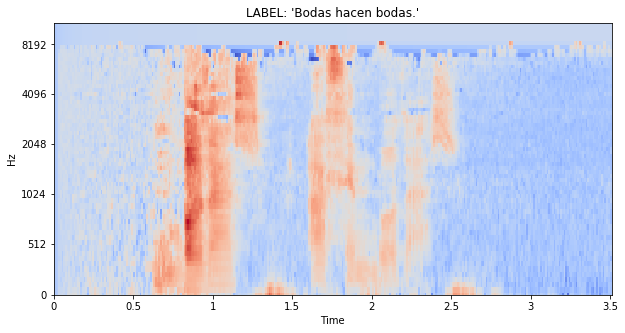

In [8]:
file_example = X_train[5];

# Both feature and label are obtained using the name of the file
file_data = hf[file_example+'-spec'];
file_label = labels[file_example];


# Then, they can be plotted as shown below.
plt.figure(figsize=(10,5))
specshow(file_data, y_axis = 'mel', sr = fs, x_axis = 'time')
plt.title('LABEL: \'{}\''.format(file_label));


# Generator to read features and labels
We can reuse the previous approach to create a generator, which might be useful to train a model using keras.


In [9]:
def generate_arrays_autoencoder(h5_file, label_dict, x_list, batch_size):
    '''
    h5_file: hdf5 file where features are stored. It must be already open using 'r' mode.
    x_list: list of files to be read from the hdf5 storage. We can use a list of names from
    the train, validation or test subset, which makes this function highly reusable.
    batch_size: defines how many audio files we want to include in our batches.
    '''
    while True:
        # For every new epoch, the 'x_list' is resampled.
        x_list_rand = random.sample(x_list,len(x_list));
        
        # This loop generates the batches. 
        for i in np.arange(0,len(x_list_rand),batch_size):
            
            '''
            The original shape of our files is (n_mel, time). In order to create a batch,
            need an additional dimension that identifies each one of the files. For that
            chore we use np.expand_dims, which creates the new structure:
              -> (n_mel, time, file_index).
            '''
            x_aux = [np.expand_dims(h5_file[x_list_rand[j]+'-spec'],axis=2) for j in np.arange(i, np.min([i+batch_size, len(x_list_rand)]))]
            
            
            '''
            We read the temporal length of each file. In fact, when processing audio it is
            quite common that files have different temporal durations. Consequently, we
            measure their lengths and add zero-padding so all of them have the same
            temporal length.
            '''
            x_aux_shape = [i.shape[1] for i in x_aux];
            
            # Add padding when necessary
            for ind in range(len(x_aux_shape)):
                x_aux[ind] = np.pad(x_aux[ind],
                                  ((0,0),
                                   (np.max(x_aux_shape)-x_aux_shape[ind],0),
                                   (0,0)),
                                  'constant',constant_values = 0)

                
            # This line might be useful if for some reason the temporal duration is huge.
            # It essentially cuts each signal to have a duration of 1 minute (maximum).
                x_aux[ind] = x_aux[ind][0:int(1*60/win_length)]
                
            # Once that all the features are read and have the same duration, we concatenate them.
            x_aux = np.concatenate(x_aux, axis=2)
                
            '''
            We transpose the batch so it has a shape compatible with our keras 
            configuration. Since currently we are working on a LSTM model, we keep the 
            following structure: 
               -> (file_index, time, n_mel)
            '''            
            x = np.transpose(x_aux, [2,1,0])
            
            
            '''
            For an autoencoder, the output can be defined as follows, where (y ~ X)
            considering that we scaled y within the range [-1,1].
            '''
            y = x/(np.max(np.abs(x))+1e-30); 
            
            '''
            Alternatively, if we want to train (for example) a seq-2-seq model, we can
            use the labels available in the dataset.
            '''
            y = [label_dict[x_list_rand[j]] for j in np.arange(i, np.min([i+batch_size, len(x_list_rand)]))]

            try:
                yield (x,y)
            except StopIteration:
                return   

The generator that we propose can be used in keras (fit_generator function) using the following line for the following configuration:
* Training subset.
* Batch size of two elements.

In [13]:
train_generator = generate_arrays_autoencoder(hf, labels, X_train, 2)

# Training a model
We leave this part for another job. However, we can use the whole code explained in the previous sections of this notebook.